<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/Enhance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload an image (JPG/PNG)...


Saving IMG_9094.jpeg to IMG_9094 (1).jpeg


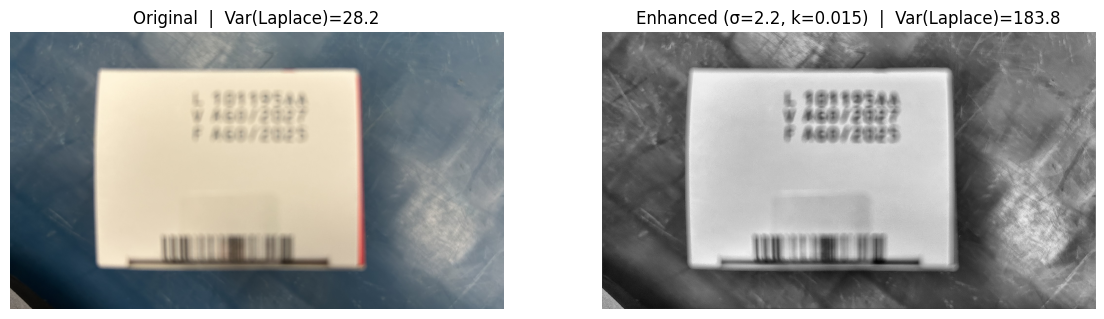

Saved processed image to: enhanced_gray.png


In [4]:
# -*- coding: utf-8 -*-
# Colab-ready: upload an image, deblur/enhance, show original vs processed.

import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---------------------------
# Utilidades de enfoque
# ---------------------------

def var_laplacian(gray: np.ndarray) -> float:
    """Medir nitidez: varianza del Laplaciano (mayor => más enfocado)."""
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def gaussian_psf(shape, sigma: float) -> np.ndarray:
    """Generar PSF (Point Spread Function) gaussiano centrado."""
    h, w = shape
    y, x = np.indices((h, w))
    cy, cx = h // 2, w // 2
    psf = np.exp(-((x - cx) ** 2 + (y - cy) ** 2) / (2.0 * sigma ** 2))
    psf /= psf.sum() + 1e-12
    return psf.astype(np.float32)

def wiener_deconv(img: np.ndarray, psf: np.ndarray, k: float = 0.01) -> np.ndarray:
    """Deconvolución de Wiener en dominio de Fourier."""
    eps = 1e-7
    G = np.fft.fft2(img)
    H = np.fft.fft2(np.fft.ifftshift(psf), s=img.shape)
    H_conj = np.conj(H)
    denom = (np.abs(H) ** 2) + k
    F_hat = (H_conj / (denom + eps)) * G
    rec = np.fft.ifft2(F_hat).real
    rec = np.clip(rec, 0.0, 1.0).astype(np.float32)
    return rec

def enhance_focus_better(bgr: np.ndarray):
    """
    Pipeline de mejora:
      1) Gris + métrica de blur
      2) Estima sigma del PSF y k para Wiener
      3) Deconvolución + Unsharp Mask
      4) CLAHE para contraste local
    Devuelve imagen en gris 8-bit y métricas.
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    blur_before = var_laplacian(gray)

    # Estimar sigma y k según nivel de desenfoque (heurístico)
    if blur_before < 20:
        sigma, k = 3.0, 0.02
    elif blur_before < 60:
        sigma, k = 2.2, 0.015
    elif blur_before < 120:
        sigma, k = 1.6, 0.01
    else:
        sigma, k = 1.2, 0.008

    # Deconvolución de Wiener
    img_f32 = (gray.astype(np.float32) / 255.0)
    psf = gaussian_psf(img_f32.shape, sigma)
    rec = wiener_deconv(img_f32, psf, k=k)

    # Unsharp mask suave
    blurred = cv2.GaussianBlur(rec, (0, 0), 1.0)
    sharpen = cv2.addWeighted(rec, 1.6, blurred, -0.6, 0)

    # CLAHE (contraste local adaptativo)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    out_u8 = (np.clip(sharpen, 0, 1) * 255).astype(np.uint8)
    out_u8 = clahe.apply(out_u8)

    blur_after = var_laplacian(out_u8)
    return out_u8, blur_before, blur_after, sigma, k

# ---------------------------
# Subir imagen
# ---------------------------
print("Upload an image (JPG/PNG)...")
uploaded = files.upload()
fname = next(iter(uploaded.keys()))

# Leer con OpenCV (BGR)
bgr = cv2.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError("Could not read the uploaded image.")

# Procesar
enhanced_gray, blur_before, blur_after, sigma_used, k_used = enhance_focus_better(bgr)

# Guardar resultado
out_path = "enhanced_gray.png"
cv2.imwrite(out_path, enhanced_gray)

# Mostrar lado a lado
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
plt.title(f"Original  |  Var(Laplace)={blur_before:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced_gray, cmap="gray")
plt.title(f"Enhanced (σ={sigma_used:.1f}, k={k_used:.3f})  |  Var(Laplace)={blur_after:.1f}")
plt.axis("off")
plt.show()

print(f"Saved processed image to: {out_path}")
